In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


diabetes_data = pd.read_csv('diabetes.csv')

columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
columns_nums = diabetes_data.select_dtypes(include=['int64', 'float64'])

diabetes_data[columns_with_zeros] = diabetes_data[columns_with_zeros].replace(0, np.nan)

X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def log_transform(x):
    return np.log(x + 1)

log_transformer = FunctionTransformer(log_transform)
# imputer pour remplacer les valeurs manquantes
imputer = SimpleImputer(strategy='median')


preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', imputer, columns_with_zeros),
    ]
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'poly__degree': [1, 2],
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(classification_rep, accuracy)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154
 0.7727272727272727


In [58]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Glucose', 'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI'])])),
                ('poly', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=9))])

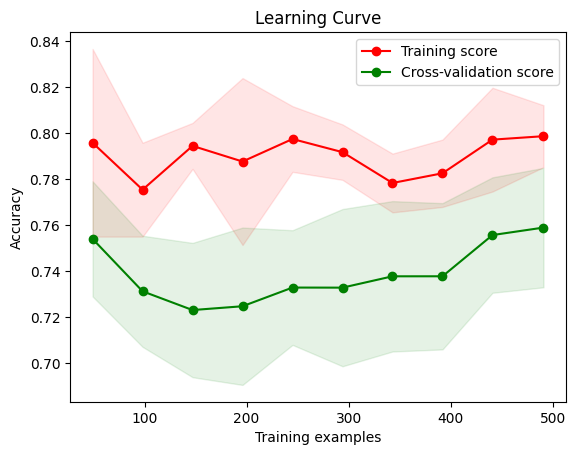

In [59]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = best_model,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'accuracy'
)

train_scores_mean = train_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis = 1)

# Assurez-vous que best_model est défini
# best_model = grid_search.best_estimator_

# Code pour tracer la courbe d'apprentissage
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()

plt.show()